<img src="./coverimage.jpg"/>
Cover Image: tabaca/Shutterstock

# Chapter 3 - Types of data

## Install Python libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

!pip3 install pandas statsmodels scipy statistics seaborn wordcloud nltk gstools scikit-gstat networkx  --user

## Import libraries

In [ ]:
import os
from os import path

import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

from dateutil import parser, rrule
from datetime import datetime, time, date

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import reuters

import PIL
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageDraw
from PIL import ImageFont

from statsmodels.graphics.tsaplots import plot_acf

import skgstat as skg
import gstools as gs
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

## Plot settings

In [ ]:
%matplotlib inline

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (14, 14),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

xxlarge = 16
xlarge = 16
large = 12

plt.rcParams.update(params)
plt.rcParams['font.size'] = '26'

# Plot style
sns.set()
sns.set_style("white")

# Tabular Data
**Example 3.1**: To illustrate tabular data consider the data set capturing the hourly rainfall, temperature and humidity in London recorded by the UK Met Office in 2015; see Table 3.1 for a sample of monthly summaries. A stacked bar chart can be used to visually compare the magnitude of features such as temperature and humidity. To make the comparison meaningful we divide the monthly averages by the yearly average. This gives rise to the stacked bar chat shown in Figure 3.1.

In [ ]:
station = 'ILONDONL28'
data_raw = pd.read_csv('./data/ILONDONL28_weather.csv')

# Change the column names to make them simpler and more readable.
data_raw['temp'] = data_raw['TemperatureC'].astype(float)
data_raw['rain'] = data_raw['HourlyPrecipMM'].astype(float)
data_raw['total_rain'] = data_raw['dailyrainMM'].astype(float)
data_raw['date'] = data_raw['DateUTC'].apply(parser.parse)
data_raw['humidity'] = data_raw['Humidity'].astype(float)

# Extract the columns of the data we require
data = data_raw.loc[:, ['date', 'station', 'temp', 'rain', 'total_rain', 'humidity']]
data = data[(data['date'] >= datetime(2015, 1, 1)) & (data['date'] <= datetime(2015, 12, 31))]
    
# Remove outliers
data = data[data['rain'] > -500]

# Extract time, day, and hour from each timestamp in the data
data['time_of_day'] = data['date'].apply(lambda x: x.time())
data['day_of_week'] = data['date'].apply(lambda x: x.weekday())    
data['hour_of_day'] = data['time_of_day'].apply(lambda x: x.hour)
data['month'] = data['date'].apply(lambda x: x.month)

df = data[['month', 'hour_of_day', 'humidity','total_rain', 'temp']]

df_mean = df.groupby(by='month').mean()

# take the average over the year
avg1 = df_mean[['temp']].mean()[0]
avg2 = df_mean[['humidity']].mean()[0]

df[['temp']] = df_mean[['temp']] / avg1
df[['humidity']] = df_mean[['humidity']] / avg2
df.set_index('month', inplace=True)

print(df_mean[['temp', 'humidity']].head())

Table 3.1: A sample of the rainfall data set recording the average temperature and humidity in London summarised on a monthly basis.

In [ ]:
ax = df_mean[['temp', 'humidity']].plot.bar(stacked=True, rot=0)
ax.set_xlabel("Month", fontsize=xlarge)

ax.tick_params(axis='both', which='major', labelsize=xlarge)
ax.legend(['Temperature', 'Humidity'], fontsize=xlarge)

plt.tight_layout()

Figure 3.1: A stacked bar chart displaying the monthly temperature and humidity recorded in London in 2015 by the UK Met Office.

**Example 3.2**: Consider a breakfast cereal data set, containing multiple features describing 77 commonly available breakfast cereals, with information captured on food labels including amongst other features: protein, fat, sodium, fibre, carbohydrates (carbo) and potassium (potass); see Table 3.2 for a matrix describing the Pearson correlation between pairs of a sample of features from the data set. The heatmap, shown in Figure 3.2, reveals, for example, that there is a strong correlation between the amount of fibre and potassium contained in cereals, which promotes digestive health.

In [ ]:
# read dataset
df = pd.read_csv('./data/cereal.csv')

# remove unnecessary fields
fields = ['name', 'mfr', 'type', 'rating', 'shelf', 'cups', 'weight','sugars','vitamins','fat']

# remove the associated rows 
df.drop(fields, axis='columns', inplace=True)
print(df.head())

# get correlations and reassign to dataframe variable
df = df.corr()

print(df.head(6))

Table 3.2: A matrix of the Pearson correlation between each pair of a 
sample of features from the breakfast cereal data set.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# mask
mask = np.triu(np.ones_like(df, dtype=bool))
# adjust mask and df
mask = mask[1:, :-1]

# plot heatmap
sns.heatmap(df, annot=True, fmt=".2f")

plt.yticks(rotation=0)
ax.set_xlim([0,6])
ax.set_ylim([0,6])

ax.tick_params(axis='both', which='major', labelsize=xlarge)

Figure 3.2: A heatmap of the pairwise Pearson Correlation scores generated 
from the matrix representation for the breakfast cereal data set


**Example 3.3**: Consider a data set of the time, location and magnitude of earthquakes (in the Richter scale) for the month of July recorded from sensor sites around the world during 2021 and published by the U.S. Geological Survey (USGS); see Table 3.3. The histogram depicting the distribution of recorded magnitudes of earthquakes is shown in Figure 3.3; noting that we have already introduced to histograms in Chapter 2 as a means to plot the distribution of a numeric feature.

In [ ]:
df = pd.read_csv('./data/quakes_all_month.csv')

print(df[['time', 'latitude', 'longitude', 'depth', 'mag']].head())

Table 3.3: Sample of the magnitude of earthquakes, on the Richter scale, recorded around the world during July 2021.a.

In [ ]:
df.set_index('time', inplace=True)
ax = df['mag'].plot.hist()
ax.set_ylabel('Count')
ax.set_xlabel('Magnitude (Mag)')

Figure 3.3: Histogram depicting the distribution of recorded magnitudes for earthquakes world-wide in July 2021

**Example 3.4**: Consider a data set that contains the salary, in US dollars, of 30 individuals against their years of work experience; see Table 3.4. A scatter plot of salaries against their years of experience, together with a linear regression line fitted to the data is shown in Figure 3.4.

In [ ]:
df = pd.read_csv('./data/Salary_Data.csv')
X = df.iloc[:,:-1].values
Y = df.iloc[:,1].values

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.33, random_state = 0)
 
# fit the regression model
model = LinearRegression()
model.fit(X_train, y_train)
 
# predict the test set results
y_pred = model.predict(X_test) 

print(df.head())  

print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Table 3.4: Years of experience against the salary, in US dollars, for a sample of individuals in the data.

In [ ]:
g = sns.lmplot(x="YearsExperience", y="Salary", data=df);

plt.xlabel("Experience (years)", fontsize=xlarge) # adding the name of x-axis
plt.ylabel("Salary ($)", fontsize=xlarge) # adding the name of y-axis
plt.tick_params(axis='both', which='major', labelsize=xlarge)

for ax in g.axes.flat:
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

plt.tight_layout()

Figure 3.4: A scatter plot of the salary for 30 individuals against their years of experience, together with a linear regression line fitted to the data.

# Textual data
**Example 3.5**: A word cloud is a visual representation of a collection of 
words, where the size and font of words is displayed according to their iportance in the text, which is often just their frequency of occurrence 
In Figure 3.5 a word cloud summarising the Reddit posts during 2021  n
the Coronavirus pandemic, is shown. The word cloud is constructed f the most frequent 38,058 words from all posts with very common stop words 
such as “the”, “it” and “at” removedrom


In [ ]:
# Using our Reddit data from 01/06/2021
df = pd.read_csv("./data/reddit_text.csv", index_col=0)
text = " ".join([t for t in df.text]).lower()

stopwords = set(STOPWORDS)
stopwords2 = ['b']#["really","probably","please","wiki","message","compose","believe","still","time","know","think","removed","covid","coronavirus","comments","B","S","well","https","even","will","reddit","comment ","comment","post","make", "now", "going", "made", "will"]

for s in stopwords2:
    stopwords.add(s)

wc = WordCloud(width=1600, height=800, stopwords=stopwords, collocations=True, background_color="white", max_font_size=100, max_words= 500).generate(text)

plt.figure( figsize=(10,10))
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad=0)

Figure 3.5: A word cloud summarising the most frequent words captured from Reddit posts published in 2021 on the topic of the Coronavirus pandemic.

**Example 3.6**: One way to visualise the distribution of words in a corpus is the Zipf plot, named after the linguist George Kingsley Zipf who studied the statistical properties of texts. A Zipf plot is constructed in two steps; see Section 3.7. In the first step we apply a rank transformation to the data by ordering the words in the corpus according to frequency and ranking them from most frequent to least frequent resulting in a distribution called a rank-order distribution. Then, in the second step, we apply the log-log transformation to the ranked data and the plot of this transformation is called a Zipf plot.

<div class="alert alert-info" role="alert">
    <div class="row vertical-align">
        <div class="col-xs-1 text-center">
            <i class="fa fa-exclamation-triangle fa-2x"/>
        </div>
        <div class="col-xs-11">
            <strong>This example takes several minutes to run due to the size of the corpus. You can limit the amount of time taken by adjusting the `sample_size` variable, but the plots may vary from those in the book.</strong>
        </div>
    </div>
</div>

In [ ]:
nltk.download('reuters')

sample_size = 1720901
stopwords = set()
for p in string.punctuation: 
   stopwords.add(p)

reuters_words = []
print(reuters.words())

n = 0
for w in reuters.words():
    if n >= sample_size: 
        break
    w = w.lower()
    reuters_words.append(w)
    n += 1
    
words = set(reuters_words)
counts = [(w, reuters_words.count(w)) for w in words if w not in stopwords]

term_freq_df = pd.DataFrame(counts)
term_freq_df.columns = ["word", "total"]
term_freq_df.sort_values(by='total', ascending=False, inplace=True)

X = [x+1 for x in np.arange(500)]
y_pos = term_freq_df['total'][:len(X)]

s = 1

expected_zipf = [term_freq_df['total'][0]/(i + 1)**s for i in y_pos]
print(pd.DataFrame(expected_zipf).head(10))

Table 3.5: A sample of the rank position and the total term frequency in thousands for the top-10 words in the Reuters corpus of financial news documents.

In [ ]:
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

ax1.plot(X, y_pos, color='r', linestyle='--',linewidth=2)

ax1.set_xlabel('Rank', fontsize=xlarge)
ax1.set_ylabel('Frequency', fontsize=xlarge)

ax2.plot(np.log(X), np.log(y_pos), '--r', linewidth=2)
ax2.set_xlabel('log (Rank)', fontsize=xlarge)
ax2.set_ylabel('log (Frequency)', fontsize=xlarge)

ax1.tick_params(axis='both', which='major', labelsize=xlarge)
ax2.tick_params(axis='both', which='major', labelsize=xlarge)

Figure 3.6: A rank-order distribution (left) and Zipf plot (right), of the 500 most frequent words captured the Reuters corpus.

# Image, Video and Audio Data
**Example 3.7**: A contact sheet of thumbnails displaying a preview of the 
cat and dog image recognition data set is shown in Figure 3.7. This dat 
set is used for the purpose of Asirra (Animal species image recognition f r
restricting access), which asks users to identify photographs of cats  nd
dogs, acting as a CAPTCHA (Completely Automated Public Turing tes  to
tell Computers and Humans Apart) for some web sites requiring restr cted
access.

In [ ]:
def create_thumbnails(fnames, colrow, photodim, margins, padding):
    # Read in all images and resize appropriately
    ncols, nrows = colrow
    photow, photoh = photodim
    mar_l, mar_t, mar_r, mar_b = margins
    
    imgs = [Image.open(fn).resize((photow, photoh)) for fn in fnames]

    # Calculate the size of the output image, based on the
    #  photo thumb sizes, and including margins, and padding
    mar_w = mar_l + mar_r
    mar_h = mar_t + mar_b

    pad_w = (ncols - 1) * padding
    pad_h = (nrows - 1) * padding
    isize = (ncols * photow + mar_w + pad_w, nrows * photoh + mar_h + pad_h)

    # Create the new image. The background doesn't have to be white
    white = (255, 255, 255)
    inew = Image.new('RGB', isize, white)

    # Insert each thumb:
    for irow in range(nrows):
        for icol in range(ncols):
            left  = mar_l + icol * (photow + padding)
            right = left + photow
            upper = mar_t + irow * (photoh + padding)
            lower = upper + photoh
            bbox  = (left, upper, right, lower)
            try:
                img = imgs.pop(0)
            except:
                break
            inew.paste(img,bbox)
    return inew


path = "./data/images/"
files = [path + fn for fn in os.listdir(path)]

photow, photoh = 200, 150
photo = (photow, photoh)
ncols = 5
nrows = 5
margins = [5, 5, 5, 5]
padding = 1

# This line will allow us to skip files we do not need given the dimensions of our contact sheet.
if len(files) > ncols * nrows: files = files[ :ncols * nrows]

inew = create_thumbnails(files, (ncols, nrows), photo, margins, padding)
inew.show()

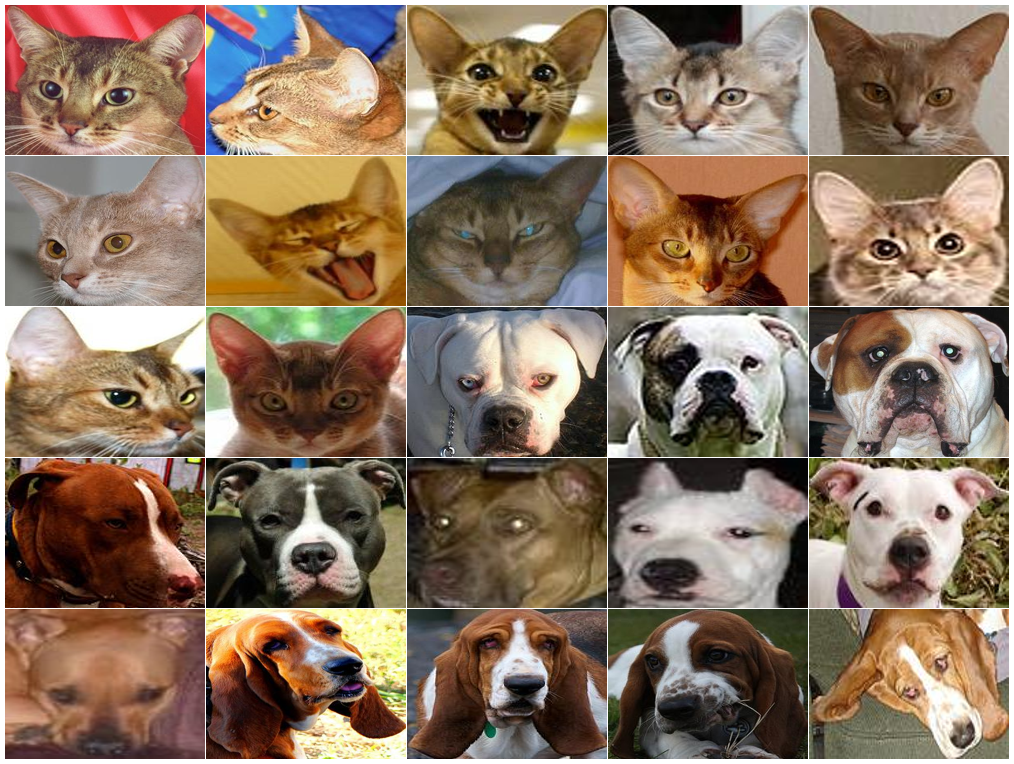

Figure 3.7: A sample of a collection of over three million images of cats and dogs for use as CAPTCHAs from the Asirra data set.

# Time series Data
**Example 3.8**: Consider a data set describing the monthly count of observed 
sunspots for over 230 years (1749-1983), with 2,820 total observations; se 
Table 3.6 for a sample of the data and the top of Figure 3.8 for the visualis d
time series. The moving average method smooths a time series by replac ng
each of the raw values in a time series by the average of several values wi hin
a window of a given size, where the centre of the wind w is position d on
the value being replaced. The moving average for the sunspot data,  ith a
window of 12 months, is shown in the middle of Figure 3.8. A core logram
or an autocorrelation (see Section 2.3) plot, shows the autocorrela ion for
range of time lags starting from zero when its value  s 1. The co relogram
for the sunspot data is shown at the bottom of Fgure 3.8.


In [ ]:
df = pd.read_csv('./data/monthly-sunspots.csv')
df.set_index('Month', inplace=True)
print(df.head())

Table 3.6: A sample of the sunspot data showing the year and month, and the total count of sun spots observed.

In [ ]:
ax1 = plt.subplot2grid((3,1), (0,0))
ax2 = plt.subplot2grid((3,1), (1,0))
ax3 = plt.subplot2grid((3,1), (2,0))

df.plot(ax=ax1)
df.rolling(window=12).mean().plot(ax=ax2)

series = df[['Sunspots']]
plot_acf(series, ax=ax3)

ax1.set_xlabel("", fontsize=xlarge)
ax1.set_ylabel("#Sunspots", fontsize=xlarge)

ax2.set_xlabel("Year-Month", fontsize=xlarge)
ax2.set_ylabel("Mean #Sunspots", fontsize=xlarge)

ax3.set_xlabel("Lag", fontsize=xlarge)
ax3.set_ylabel("Autocorrelation", fontsize=xlarge)
ax3.set_title('')
ax3.set_ylim([-0.4,1.1])

ax1.tick_params(axis='both', which='major', labelsize=xlarge)
ax2.tick_params(axis='both', which='major', labelsize=xlarge)
ax3.tick_params(axis='both', which='major', labelsize=xlarge)

plt.tight_layout()

Figure 3.8: The count of monthly sun spots visualised as the raw time series (top), a moving average of the time series with a window size of 12 months representing a year of observations (middle), and a correlogram of the time series with a 95% confidence interval about 0 (bottom).

**Example 3.9**: The variogram is a function showing the degree of spatial continuity of spatial data; it calculates, for an input distance, the variability between pairs of data points separated by that distance. So, we expect the output of a variogram to grow with the distance, i.e. we expect a monotonically increasing relationship between distance and variability. The smallest distance at which the variability is very close to the maximum variability is called the range, and the actual variability at the range (which is essentially the maximum variability) is called the sill. The nugget is the variability when the distance is close to zero; in practice it is greater than zero, which could be due to measurement error. Consider a data set providing the locations and topsoil heavy metal concentrations recorded in a flood plain of the river Meuse, near the village of Stein in the Netherlands, where the survey of heavy metal concentrations were taken from composite samples of an area of 15 square metres; see Table 3.7. Figure 3.9 shows the variogram for this data set.

In [ ]:
coordinates, values = skg.data.meuse('copper').get('sample')

x = np.array([c[0] for c in coordinates])
y = np.array([c[1] for c in coordinates])
field = np.array([i[0] for i in values])

# combine x and y for use in skgstat
V = skg.Variogram(coordinates, field, n_lags=100, estimator='matheron', bin_func='even', return_r2=True)#, maxlag=22)

bin_center, gamma = V.get_empirical(bin_center=True)

# fit the variogram with a stable model. (no nugget fitted)
fit_model = gs.Spherical(dim=1)
para = fit_model.fit_variogram(bin_center, gamma)

sill = 574.90
rangeof = 864.08

# Print a sample of the data as a dataframe and the parameters
d = zip(coordinates, values)
temp = []
for i in d:
    temp.append((i[0][0],i[0][1], i[1][0]))
    
df = pd.DataFrame(temp, columns=['x','y', 'value'])

print(df.head())
print(para)

Table 3.7: The longitude and latitude columns represent map coordinates, and the third column records the topsoil copper concentration in parts per million (ppm).

In [ ]:
ax = fit_model.plot(x_max=max(bin_center))

ax.scatter(bin_center, gamma, color='red')
ax.plot(lw=4.5, legend=False, c="red")

ax.legend([])
ax.set_xlim([0,1000])

ax.axhline(y=sill, alpha=0.8, lw=3.5, ls="--", color="orange")
ax.axvline(x=rangeof, alpha=0.8, ls="--", lw=3.5, color="green")

ax.tick_params(axis='both', which='major', labelsize=xlarge)
ax.set_xlabel('Lag distance', fontsize=xlarge)
ax.set_ylabel('Variance', fontsize=xlarge);

ax.annotate('nugget', xy=(15,163.25),  xycoords='data',
            xytext=(0.1, 0.1), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='top',fontsize=14,
)

ax.annotate('sill', xy=(10, 550),  xycoords='data',
            xytext=(0.1, 0.6), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='top',fontsize=14,
)

ax.annotate('range', xy=(rangeof-20, 1190),  xycoords='data',
            xytext=(0.7, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',fontsize=14
)

plt.tight_layout()

Figure 3.9: A variogram for the copper deposits with the range=864.08, the sill=574.90, and the nugget=163.25.

# Social Network Data 
**Example 3.10**: Consider the Karate Club social network data set composed of data collected, Wayne Zachary in 1977, from 34 members of a university karate club prior to the separation of the members after a dispute. In the network each node represents a member of the club, and each edge represents two members that consistently were observed to interact outside the normal activities of the club; see Table 3.8. A visualisation of the Karate Club social network is shown in Figure 3.10; the visualisation clearly shows the two factions of the club, although detailed analysis is still needed to establish the exact separation.

In [ ]:
G = nx.karate_club_graph()
print("Node Degree")

for v in G:
    print(f"{v+1:4} {G.degree(v):6}")

Table 3.8: Sample of the node ID and degree, i.e. how many edges the node participates in, for members of the Karate club social network.

In [ ]:
layout = nx.fruchterman_reingold_layout(G)

plt.axis("off") 

nx.draw_networkx(G, layout, with_labels=False, node_color = "orange" )

c = list(greedy_modularity_communities(G))

#Let's find out how many communities we detected
print("There are",len(c), "communities (clusters)")

#Lets see these 3 clusters
community_0 = sorted(c[0])
community_1 = sorted(c[1])
community_2 = sorted(c[2])

print(community_0)
print(community_1)
print(community_2)

#draw each set of nodes in a seperate colour
group1 = {}
for i in community_0:
    group1[i] = i + 1
    
group2 = {}
for i in community_1:
    group2[i] = i + 1

group3 = {}
for i in community_2:
    group3[i] = i +1

temp = {}
for i in group1.keys():
    temp[i] = group1[i]
group1 = temp

temp = {}
for i in group3.keys():
    temp[i] = group3[i]
group3 = temp
  
combined_community = community_1 + community_2
circ_pos = layout
nx.draw_networkx_labels(G, circ_pos, group1, font_size=11, font_color="black", font_weight="normal")
nx.draw_networkx_labels(G, circ_pos, group2, font_size=11, font_color="black", font_weight="normal")
nx.draw_networkx_labels(G, circ_pos, group3, font_size=11, font_color="black", font_weight="normal")

Figure 3.10: A visualisation of the Karate Club social network.

**Example 3.11**: Conversion from degrees Celsius to Fahrenheit is a linear transformation, with a = 9/5, and b = 32, giving:
$$Fahrenheit = 1.8 * Celsius + 32.$$
The table shows a sample of converted values between the two measures of temperature.

In [ ]:
def transform(C):
    return int((9 / 5) * C + 32)
    
temp = []
for cDegrees in range(0,23):
    fDegrees = transform(cDegrees)
    temp.append([cDegrees, fDegrees])
    
df = pd.DataFrame(temp, columns=['C','F'])
print(df.head())

Table 3.9: A sample of values transformed from degrees Celsius to Fahrenheit.

**Example 3.12**: An example transformation converting between a five-star rating to the scale between 0 and 1 is shown in Table 3.10.

In [ ]:
def transform(i):
    a = 0
    b = 1
    x = [1, 2, 3, 4, 5] # 5-star rating

    t1 = i - min(x)
    t2 = max(x) - min(x)

    z = (b - a) * (t1 / t2) + a
    return z

temp = []
for i in range(1, 6):
    z = transform(i)
    temp.append([i, z])
    
df = pd.DataFrame(temp)
print(df.head())

Table 3.10: A five-star rating scheme (first column) transformed to the range 0 and 1 (second column).

**Example 3.13**: Consider a data set describing the number of economically active adults in thousands, arranged into age groups, from a national UK Labour force survey published by the department for Business, Innovation and Skills (BIS) in 2010; see Table 3.11. A histogram of binned data according to age groups is shown in Figure 3.11.

In [ ]:
df = pd.read_csv('./data/economically_active_adults.csv', delimiter='\t')
df.set_index('Age', inplace=True)
print(df.head(10))

Table 3.11: Labour force survey 2010 showing the age groups and the number of working adults (#adults) in the thousands.

In [ ]:
plt.style.use('seaborn-white')

ax = df.plot(kind='bar', legend=False, rot=0,width=1)

ax.set_ylabel("#Adults (thousands)", fontsize=xlarge)
ax.set_xlabel("Age ranges", fontsize=xlarge)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

plt.tick_params(axis='both', which='major', labelsize=xlarge)
plt.tight_layout()

Figure 3.11: A histogram of the number of economically active adults (#adults) in the UK recorded in a Labour survey conducted by the department for BIS 2010.

**Example 3.14**: Consider the ranking of the most popular song streamed on a popular digital music service, on the 1st January 2017, ranked by the number of user plays.; see Table 3.12. A bar chart visualising the ranking is shown in Figure 3.12.

In [ ]:
df = pd.read_csv('./data/spotifydata2.csv', delimiter=',')
df.set_index('Artist', inplace=True)
print(df.head(10))

Table 3.12: Ranking by count of streams of songs on a popular digital music service on the 1st January 2017.

In [ ]:
ax = df.plot(position=0.75, kind="bar",legend=False, align="center",width=1)

ax.set_ylabel("#Streams", fontsize=xxlarge)
ax.set_xlabel("Artist", fontsize=xxlarge)

plt.tick_params(axis='both', which='major', labelsize=large)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
plt.tight_layout()

Figure 3.12: A bar chart of the top-10 artists ranked by the number of streams recorded on a popular music digital service on 1st January 2017.